# MVP

- Accelerated time-to-market: Launch a product quickly to gain early traction
- Idea validation: Test it with real users before investing in the full development of the product
- Market research: Gain insights into what resonates with the target audience
- Risk minimization: Reduces the time and resources needed for a product that might not achieve market success

#### Sticking to the V in MVP is essential, meaning the product must be viable. The product must provide an end-to-end user journey without half-implemented features, even if the product is minimal. It must be a working product with a good user experience that people will love and want to keep using to see how it evolves to its full potential.




## Building ML systems with feature/training/inference pipelines

#### Before diving into the specifics of the LLM Twin architecture, we must understand an ML system pattern at the core of the architecture, known as the feature/training/inference (FTI) architecture. This section will present a general overview of the FTI pipeline design and how it can structure an ML application.


## The problem with building ML systems

#### Building production-ready ML systems is much more than just training a model. From an engineering point of view, training the model is the most straightforward step in most use cases. However, training a model becomes complex when deciding on the correct architecture and hyperparameters. That’s not an engineering problem but a research problem.

#### At this point, we want to focus on how to design a production-ready architecture. Training a model with high accuracy is extremely valuable, but just by training it on a static dataset, you are far from deploying it robustly. We have to consider how to do the following:

- Ingest, clean, and validate fresh data
- Training versus inference setups
- Compute and serve features in the right environment
- Serve the model in a cost-effective way
- Version, track, and share the datasets and models
- Monitor your infrastructure and models
- Deploy the model on a scalable infrastructure
- Automate the deployments and training

## The feature pipeline

#### The feature pipeline takes raw data as input, processes it, and outputs the features and labels required by the model for training or inference. Instead of directly passing them to the model, the features and labels are stored inside a feature store. Its responsibility is to store, version, track, and share the features. By saving the features in a feature store, we always have a state of our features. Thus, we can easily send the features to the training and inference pipelines.

#### As the data is versioned, we can always ensure that the training and inference time features match. Thus, we avoid the training-serving skew problem.

## The training pipeline

#### The training pipeline takes the features and labels from the features stored as input and outputs a train model or models. The models are stored in a model registry. Its role is similar to that of feature stores, but this time, the model is the first-class citizen. Thus, the model registry will store, version, track, and share the model with the inference pipeline.

#### Also, most modern model registries support a metadata store that allows you to specify essential aspects of how the model was trained. The most important are the features, labels, and their version used to train the model. Thus, we will always know what data the model was trained on.

## The inference pipeline

#### The inference pipeline takes as input the features and labels from the feature store and the trained model from the model registry. With these two, predictions can be easily made in either batch or real-time mode.

#### As this is a versatile pattern, it is up to you to decide what you do with your predictions. If it’s a batch system, they will probably be stored in a DB. If it’s a real-time system, the predictions will be served to the client who requested them. Additionally, the features, labels, and models are versioned. We can easily upgrade or roll back the deployment of the model. For example, we will always know that model v1 uses features F1, F2, and F3, and model v2 uses F2, F3, and F4. Thus, we can quickly change the connections between the model and features.

## Benefits of the FTI architecture

- The feature pipeline takes in data and outputs the features and labels saved to the feature store.
- The training pipeline queries the features store for features and labels and outputs a model to the model registry.
- The inference pipeline uses the features from the feature store and the model from the model registry to make predictions.


#### Now that we understand better how the pattern works, we want to highlight the main benefits of using this pattern:

- As you have just three components, it is intuitive to use and easy to understand.
- Each component can be written into its tech stack, so we can quickly adapt them to specific needs, such as big or streaming data. Also, it allows us to pick the best tools for the job.
- As there is a transparent interface between the three components, each one can be developed by a different team (if necessary), making the development more manageable and scalable.
- Every component can be deployed, scaled, and monitored independently.


#### The final thing you must understand about the FTI pattern is that the system doesn’t have to contain only three pipelines. In most cases, it will include more. For example, the feature pipeline can be composed of a service that computes the features and one that validates the data. Also, the training pipeline can be composed of the training and evaluation components.

#### The FTI pipelines act as logical layers. Thus, it is perfectly fine for each to be complex and contain multiple services. However, what is essential is to stick to the same interface on how the FTI pipelines interact with each other through the feature store and model registries. By doing so, each FTI component can evolve differently, without knowing the details of each other and without breaking the system on new changes.




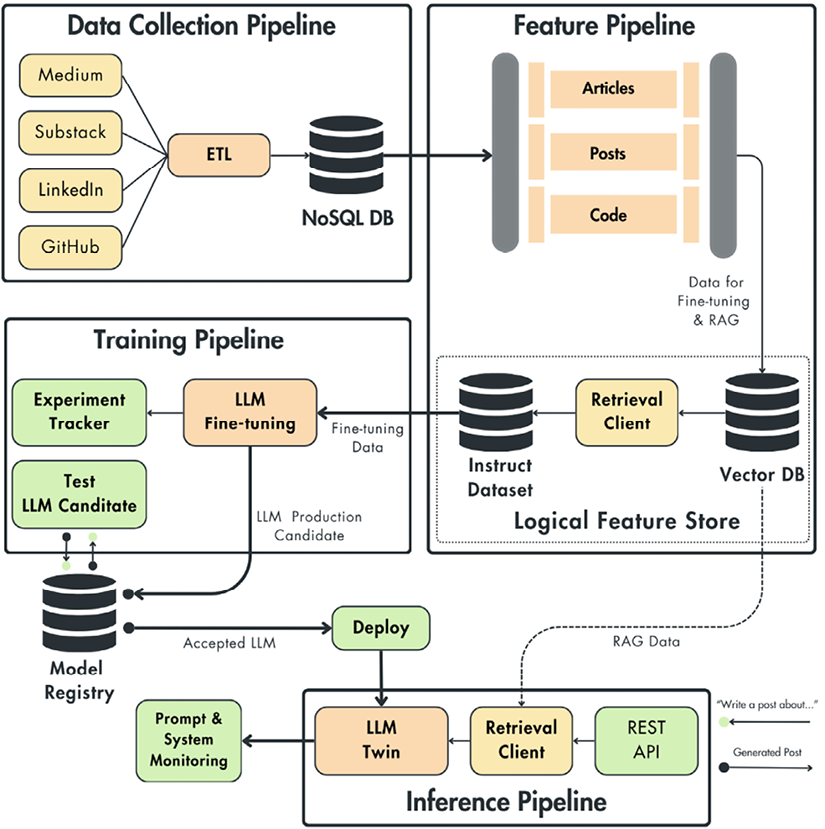

In [ ]:
from IPython.display import Image
Image(filename='/Users/maukanmir/Documents/Machine-Learning/AI-ML-Textbooks/AI-ML-Learning/images/FTI Arch.png')

## Training pipeline

#### The training pipeline consumes instruct datasets from the feature store, fine-tunes an LLM with it, and stores the tuned LLM weights in a model registry. More concretely, when a new instruct dataset is available in the logical feature store, we will trigger the training pipeline, consume the artifact, and fine-tune the LLM.

#### In the initial stages, the data science team owns this step. They run multiple experiments to find the best model and hyperparameters for the job, either through automatic hyperparameter tuning or manually. To compare and pick the best set of hyperparameters, we will use an experiment tracker to log everything of value and compare it between experiments. Ultimately, they will pick the best hyperparameters and fine-tuned LLM and propose it as the LLM production candidate. The proposed LLM is then stored in the model registry. After the experimentation phase is over, we store and reuse the best hyperparameters found to eliminate the manual restrictions of the process. Now, we can completely automate the training process, known as continuous training.

#### The testing pipeline is triggered for a more detailed analysis than during fine-tuning. Before pushing the new model to production, assessing it against a stricter set of tests is critical to see that the latest candidate is better than what is currently in production. If this step passes, the model is ultimately tagged as accepted and deployed to the production inference pipeline. Even in a fully automated ML system, it is recommended to have a manual step before accepting a new production model. It is like pushing the red button before a significant action with high consequences. Thus, at this stage, an expert looks at a report generated by the testing component. If everything looks good, it approves the model, and the automation can continue.


## Inference pipeline

#### The inference pipeline is the last piece of the puzzle. It is connected to the model registry and logical feature store. It loads a fine-tuned LLM from the model registry, and from the logical feature store, it accesses the vector DB for RAG. It takes in client requests through a REST API as queries. It uses the fine-tuned LLM and access to the vector DB to carry out RAG and answer the queries.

#### All the client queries, enriched prompts using RAG, and generated answers are sent to a prompt monitoring system to analyze, debug, and better understand the system. Based on specific requirements, the monitoring system can trigger alarms to take action either manually or automatically.